# UBC Scientific Software Seminar

## Hands-on Machine Learning with Scikit-Learn and TensorfFow

---

## Chapter 10: Introduction to Artificial Neural Networks

See [Hands-on Machine Learning with Scikit-Learn and TensorfFow](https://github.com/ageron/handson-ml) (by Aurélien Géron).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## MNIST Hand-written digits

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

Let's take a look at the data:

In [4]:
X_train.shape

(55000, 784)

In [5]:
784**0.5

28.0

The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database is a set of images of hand-written digits used for machine learning examples. The data set includes 55,000 28x28 pixel images of hand-written digits. Each sample is a vector of length 784 where the values are greyscale color values.

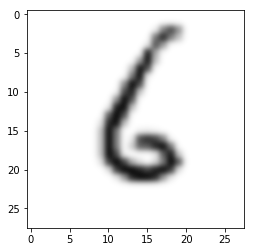

In [6]:
N = np.random.randint(0,55000) # Choose a random image in the dataset
plt.imshow(X_train[N,:].reshape(28,28),cmap='binary',interpolation='gaussian')

## PCA with Tensorflow

Let's create our own Tensorflow graph which performs [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) on the MNIST dataset. The result is that data set is projected to 2D space for us to visualize.

In [13]:
data = tf.constant(X_train,dtype=np.float32)
X = data - tf.reduce_mean(data,0)
XT = tf.transpose(X)
evals, evecs = tf.self_adjoint_eig(tf.matmul(XT,X))
pca = evecs[:,-2:]
X_transformed = tf.matmul(X,pca)

with tf.Session() as sess:
    X2D = X_transformed.eval()

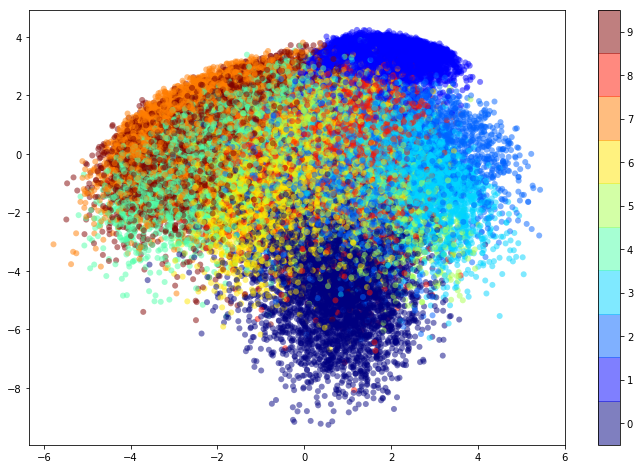

In [14]:
import matplotlib
plt.figure(figsize=(12,8))
cmap = plt.get_cmap('jet', 10)
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,10,1), cmap.N)
plt.scatter(X2D[:,0],X2D[:,1],c=y_train,lw=0,alpha=0.5,cmap=cmap,norm=norm)
plt.colorbar(ticks=np.linspace(0,9,10))
plt.show()

## Feedforward neural network (FNN) for MNIST

A [(feedforward) neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) if a function composed of layers. A layer is simple a linear function composed with a simple nonlinear function $\sigma$ called the activation function. The activation function is usually the sigmoid function $\sigma(x) = \frac{1}{1 + e^{-x}}$ or the ReLU function $\sigma(x) = \max\{x,0\}$. A typical layer looks like:

$$
L_i(W_i,b_i)(x_{i-1}) = \underline{\sigma}(W_i x_{i-1} + b_i) = x_i
$$

where $W$ is a matrix of **weights**. The size of $W$ is $m_i$ (= size of output vector $x_i$) by $m_{i-1}$ (= size of input vector $x_{i-1}$. The vector $b_i$ is called the **bias** and is of size $m_i$ (= size of output vector $x_i$). The function $\underline{\sigma}$ is simply the vectorized function which applies $\sigma$ to each entry of a vector $x$.

A (feedforward) neural network is composition of $\ell$ layers:

$$
F(x) = L_{\ell}(W_{\ell},b_{\ell}) \circ L_{\ell - 1}(W_{\ell - 1},b_{\ell - 1}) \circ \cdots \circ L_1(W_1,b_1) (x)
$$

The layers between the input and output layers are called the hidden layers. The architecture of the FNN refers to the number and size of hidden layers.

Training a neural network consists of choosing a cost function $C(W,b)$ depending on the model parameters and using gradient descent to find the optimal parameters $\{ W_i \}_i$, $\{ b_i \}_i$ relative to the cost function.

What's the point? The [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) shows that FNNs are simple nonlinear functions which can approximate *any* function. We just need to find the right arrchitecture and parameters for our applications!

In [15]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [17]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [18]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")
    # Or use built-in tensorflow function to build dense layers
    # hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    # hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    # logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [19]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [20]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [21]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
n_epochs = 40
batch_size = 50

In [24]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 1.0 Val accuracy: 0.9152
1 Train accuracy: 0.92 Val accuracy: 0.9308
2 Train accuracy: 0.96 Val accuracy: 0.9406
3 Train accuracy: 0.9 Val accuracy: 0.9472
4 Train accuracy: 0.98 Val accuracy: 0.9518
5 Train accuracy: 0.98 Val accuracy: 0.9554
6 Train accuracy: 0.94 Val accuracy: 0.9596
7 Train accuracy: 0.98 Val accuracy: 0.961
8 Train accuracy: 0.96 Val accuracy: 0.9634
9 Train accuracy: 0.98 Val accuracy: 0.9652
10 Train accuracy: 0.98 Val accuracy: 0.9664
11 Train accuracy: 1.0 Val accuracy: 0.9684
12 Train accuracy: 0.98 Val accuracy: 0.9694
13 Train accuracy: 1.0 Val accuracy: 0.9708
14 Train accuracy: 1.0 Val accuracy: 0.9714
15 Train accuracy: 0.98 Val accuracy: 0.9734
16 Train accuracy: 0.98 Val accuracy: 0.972
17 Train accuracy: 1.0 Val accuracy: 0.9728
18 Train accuracy: 1.0 Val accuracy: 0.9726
19 Train accuracy: 0.98 Val accuracy: 0.9728
20 Train accuracy: 0.98 Val accuracy: 0.9736
21 Train accuracy: 0.98 Val accuracy: 0.9752
22 Train accuracy: 0.98 Val a

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [26]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


## Visualize the computational graph for FNN

In [27]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [28]:
show_graph(tf.get_default_graph())